<a href="https://colab.research.google.com/github/Pongaaa/ComputerVision/blob/main/baitap2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Định nghĩa đường dẫn
train_path = '/content/drive/My Drive/HoaVietNam/train'
test_path = '/content/drive/My Drive/HoaVietNam/test'


In [ ]:
import os
import cv2
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# Trích xuất đặc trưng Histogram
def extract_histogram(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([image], [0, 1, 2], None, [16, 16, 16], [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [ ]:
# Trích xuất Moment màu và Màu chủ đạo
def extract_color_moment(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mean, stddev = cv2.meanStdDev(image)
    return np.concatenate([mean.flatten(), stddev.flatten()])

def extract_dominant_color(image_path, k=1):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixels = image.reshape(-1, 3)
    _, labels, centers = cv2.kmeans(np.float32(pixels), k, None,
                                    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0),
                                    10, cv2.KMEANS_RANDOM_CENTERS)
    return centers.flatten()


In [ ]:
# Hàm xuất độ chính xác khi sử dụng đặc trưng Moment màu và Màu chủ đạo
def print_combined_feature_accuracy():
    print(f"Accuracy with color moments and dominant color: {accuracy_comb}")

print_combined_feature_accuracy()

Accuracy with color moments and dominant color: 0.62


In [ ]:
# Danh sách nhãn hoa
flower_classes = {"Cuc": 0, "Dao": 1, "Lan": 2, "Mai": 3, "Tho": 4}

In [ ]:
# Nạp dữ liệu
def load_dataset(data_path, feature_extractor):
    features, labels, image_paths = [], [], []
    for flower, label in flower_classes.items():
        folder_path = os.path.join(data_path, flower)
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            feature = feature_extractor(img_path)
            if feature is not None and not np.isnan(feature).any():
                features.append(feature)
                labels.append(label)
                image_paths.append(img_path)
    return np.array(features, dtype=np.float32), np.array(labels), image_paths


In [ ]:
# Nạp dữ liệu từ bài tập 1
x_train_hist, y_train, train_paths = load_dataset(train_path, extract_histogram)
x_test_hist, y_test, test_paths = load_dataset(test_path, extract_histogram)


In [ ]:
# Hàm xuất tham số tốt nhất
def get_best_knn_params(x_train, y_train, x_test, y_test):
    weight_options = ['uniform', 'distance']
    distance_measures = ['braycurtis', 'canberra', 'correlation', 'cosine', 'euclidean', 'minkowski']
    best_accuracy = 0
    best_params = {}
    for weight, metric in itertools.product(weight_options, distance_measures):
        knn = KNeighborsClassifier(n_neighbors=7, weights=weight, metric=metric)
        knn.fit(x_train, y_train)
        y_pred = knn.predict(x_test)
        acc = accuracy_score(y_test, y_pred)
        if acc > best_accuracy:
            best_accuracy = acc
            best_params = {"weights": weight, "metric": metric}
    return best_params, best_accuracy

In [ ]:
best_params, best_accuracy = get_best_knn_params(x_train_hist, y_train, x_test_hist, y_test)
print(f"Best KNN Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy:.4f}")


Best KNN Parameters: {'weights': 'uniform', 'metric': 'braycurtis'}
Best Accuracy: 0.8800


In [ ]:
# Lưu kết quả bài tập 1
y_pred_bai1 = y_pred.copy()

In [ ]:
# Huấn luyện mô hình với đặc trưng mới
x_train_comb = np.hstack([load_dataset(train_path, extract_color_moment)[0],
                          load_dataset(train_path, extract_dominant_color)[0]])
x_test_comb = np.hstack([load_dataset(test_path, extract_color_moment)[0],
                         load_dataset(test_path, extract_dominant_color)[0]])

knn_comb = KNeighborsClassifier(n_neighbors=7, **best_params)
knn_comb.fit(x_train_comb, y_train)
y_pred_comb = knn_comb.predict(x_test_comb)
accuracy_comb = accuracy_score(y_test, y_pred_comb)


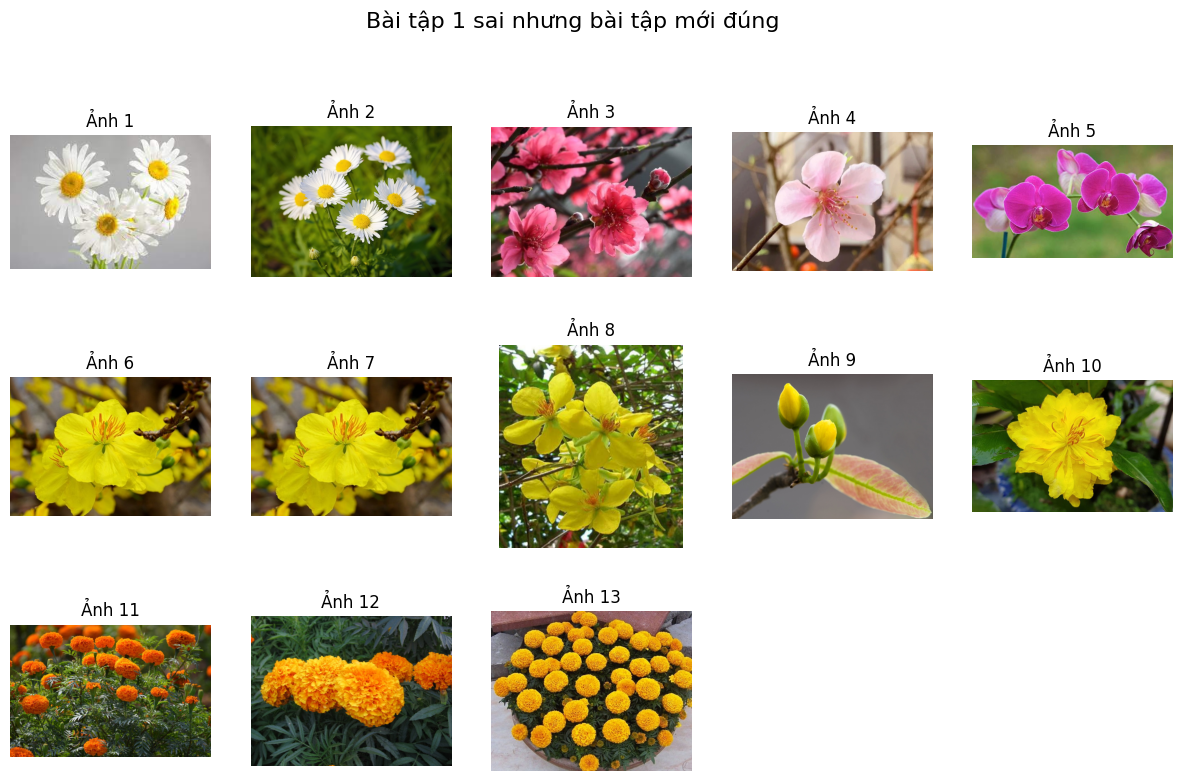

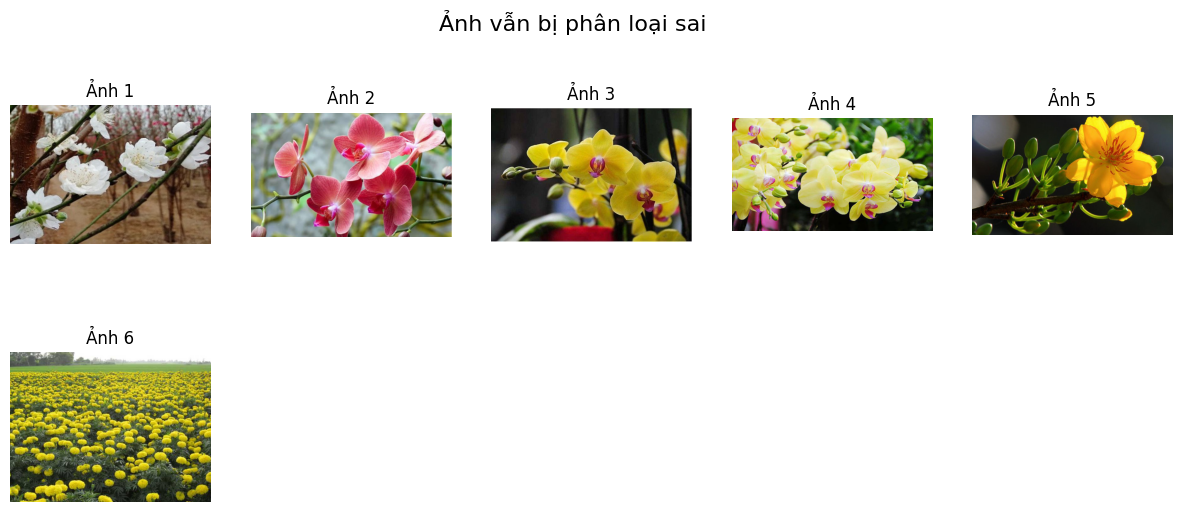

In [ ]:
# Tìm những ảnh bài tập 1 sai nhưng bài tập mới đúng
corrected_images = [test_paths[i] for i in range(len(y_test)) if (y_pred_bai1[i] == y_test[i]) and (y_pred_comb[i] != y_test[i])]

# Tìm những ảnh vẫn bị phân loại sai
still_wrong_images_bai1_best = [test_paths[i] for i in range(len(y_test)) if y_pred_bai1_best[i] != y_test[i]]

import matplotlib.image as mpimg

def show_images(image_paths, title):
    # Tạo một figure để hiển thị ảnh
    num_images = len(image_paths)
    cols = 5  # Chọn số cột để hiển thị
    rows = (num_images + cols - 1) // cols  # Tính số hàng cần thiết

    plt.figure(figsize=(15, rows * 3))  # Tạo một figure với kích thước phù hợp

    # Lặp qua danh sách các ảnh và hiển thị từng ảnh
    for idx, image_path in enumerate(image_paths):
        img = mpimg.imread(image_path)
        plt.subplot(rows, cols, idx + 1)  # Sắp xếp ảnh theo số cột và số hàng
        plt.imshow(img)
        plt.axis('off')  # Tắt trục tọa độ
        plt.title(f'Ảnh {idx + 1}')

    plt.suptitle(title, fontsize=16)  # Tiêu đề chung
    plt.show()

# Hiển thị các ảnh "bài tập 1 sai nhưng bài tập mới đúng"
show_images(corrected_images, 'Bài tập 1 sai nhưng bài tập mới đúng')

# Hiển thị các ảnh "vẫn bị phân loại sai"
show_images(still_wrong_images_bai1_best, 'Ảnh vẫn bị phân loại sai')